In [149]:
import pandas as pd
import os
import matplotlib.pyplot as plt

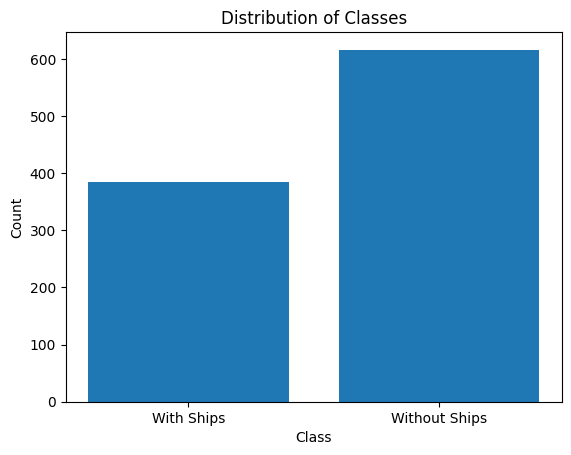

In [150]:
    # Отримання абсолютного шляху до файлу
    file_path = f'C:/Users/smolt/PycharmProjects/airbus_ship_detection_test/data_files/train_ship_segmentations_v2.csv'

    # Завантаження даних
    train_df = pd.read_csv(file_path)
    train_df = train_df.sample(n=1000, random_state=42)

    # Візуалізація розподілу класів
    ship_count = train_df['EncodedPixels'].notna().sum()
    no_ship_count = len(train_df) - ship_count

    plt.bar(['With Ships', 'Without Ships'], [ship_count, no_ship_count])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Classes')
    plt.show()

Архітектура U-Net для виявлення кораблів

In [151]:
import tensorflow as tf
from tensorflow.keras import layers

In [152]:
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.Concatenate()([conv2, up1])
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.Concatenate()([conv1, up2])
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    # Create the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [153]:
from sklearn.model_selection import train_test_split

In [154]:
    # Ім'я зображення та розмітка
    train_image_dir = 'train_images/'
    train_df['ImageId'] = train_df['ImageId'].apply(lambda x: os.path.join(train_image_dir, x))

    # Фільтрація зображень, на яких є кораблі
    ships = train_df['EncodedPixels'].notna()
    train_df = train_df[ships]

    # Розділення на тренувальний та валідаційний набори
    train_files, val_files = train_test_split(train_df['ImageId'], test_size=0.1, random_state=42)

    print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 345, Validation samples: 39


In [155]:
    # Розмірність вхідних зображень
    input_shape = (256, 256, 3)

In [156]:
    # Створення та компіляція моделі
    model = unet_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Створення класу кастомного генератора даних для ефективного завантаження пакетів під час тренування.

In [157]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

In [158]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, files, batch_size=16, image_size=(256, 256), shuffle=True, train_df=None):
        self.files = files
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train_df = train_df

    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.files[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.files = shuffle(self.files)

    def __data_generation(self, batch_files):
        X = np.zeros((self.batch_size, *self.image_size, 3))
        y = np.zeros((self.batch_size, *self.image_size, 1))
            
        for i, file in enumerate(batch_files):
            img = cv2.imread(f'C:/Users/smolt/PycharmProjects/airbus_ship_detection_test/{file}')
            mask = self.__masks_from_file(file)

            X[i,] = cv2.resize(img, self.image_size)
            y[i,] = np.expand_dims(cv2.resize(mask, self.image_size), axis=-1) / 255.0

        return X, y

    def __masks_from_file(self, file):
        masks = np.zeros((768, 768, 1), dtype=np.uint8)  # Змінено форму маски

        img_masks = self.train_df.loc[self.train_df['ImageId'] == file, 'EncodedPixels'].tolist()
        for mask in img_masks:
            if pd.notna(mask):
                masks[:, :, 0] += self.__rle_decode(mask)  # Використовуємо перший канал маски

        return masks

    def __rle_decode(self, mask_rle):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(768 * 768, dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(768, 768, order='F')

In [159]:
    # Створення генераторів даних
    train_generator = DataGenerator(train_files, batch_size=16, train_df=train_df)
    val_generator = DataGenerator(val_files, batch_size=16, train_df=train_df)

In [160]:
    # Навчання моделі
    model.fit(train_generator, epochs=2, validation_data=val_generator)

Epoch 1/2
21/21 [==============================] - 324s 15s/step - loss: 0.0072 - accuracy: 0.9971 - val_loss: 0.0014 - val_accuracy: 0.9981
Epoch 2/2
21/21 [==============================] - 338s 16s/step - loss: 0.0024 - accuracy: 0.9972 - val_loss: 6.4365e-04 - val_accuracy: 0.9982


In [164]:
import random

# Визначення кількості зображень для виведення
num_images_to_display = 5

# Ініціалізація пустого списку для збереження результатів
display_images = []
display_predictions = []

# Визначення кількості зображень для виведення
num_images_to_display = 5

# Отримання випадкових індексів
random_indices = random.sample(range(len(train_df)), num_images_to_display)

# Ініціалізація списку для збереження результатів
display_images = []
display_predictions = []

1/1 [==============================] - 0s 241ms/step


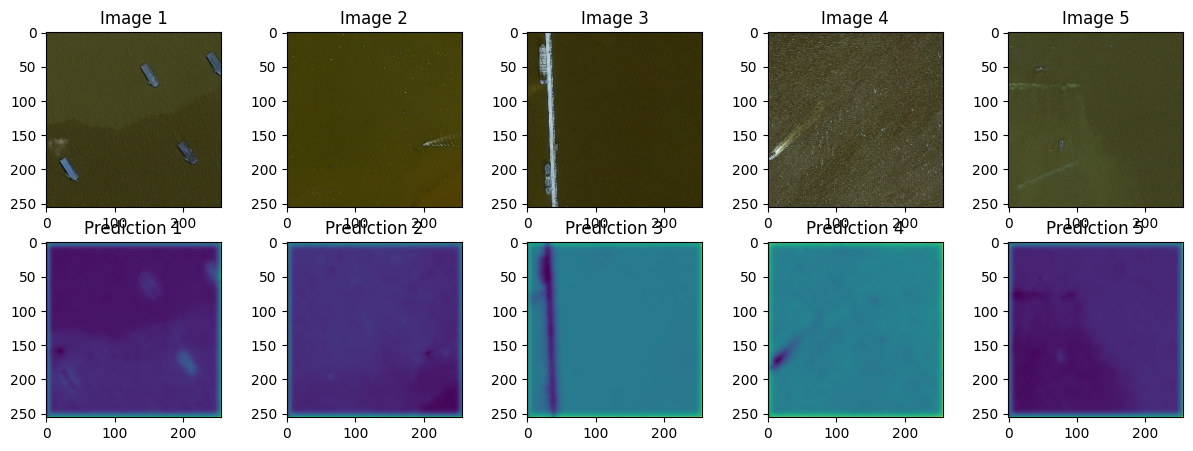

In [165]:
# Отримання випадкових зображень та їх передбачень
for index in random_indices:
    image_id = train_df.iloc[index]['ImageId']
    image_path = f'C:/Users/smolt/PycharmProjects/airbus_ship_detection_test/{image_id}'
    test_image = cv2.imread(image_path)
    test_image_resized = cv2.resize(test_image, (256, 256)) / 255.0
    test_image_resized = np.expand_dims(test_image_resized, axis=0)

    # Отримання сегментаційної маски
    predictions = model.predict(test_image_resized)

    # Збереження зображення та його передбачення
    display_images.append(test_image_resized[0])
    display_predictions.append(predictions[0, :, :, 0])

# Відображення зображень та їх передбачень
plt.figure(figsize=(15, 5))
for i in range(num_images_to_display):
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(display_images[i])
    plt.title(f'Image {i + 1}')

    plt.subplot(2, num_images_to_display, i + 1 + num_images_to_display)
    plt.imshow(display_predictions[i])
    plt.title(f'Prediction {i + 1}')

plt.show()